In [8]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import interpolate
from tqdm import tqdm

In [9]:
dlc_base_dir = os.path.abspath("../bucket/Data/Behavior_videos/DLC_output/Bergamo-2P-Photostim/")
bpod_path = os.path.abspath("../bucket/Data/Behavior/BCI_exported/Bergamo-2P-Photostim/")
suite2p_path = os.path.abspath("../bucket/Data/Calcium_imaging/suite2p/Bergamo-2P-Photostim/")
sessionwise_data_path = os.path.abspath("../bucket/Data/Calcium_imaging/sessionwise_tba/")
plt_save_path = os.path.abspath("../Plots/")
aligned_data_path = os.path.abspath("/home/labadmin/Github/BCI_analysis/data_aligned")


mouse = "BCI_26"
FOV = "FOV_04"
camera = "side" 
session = "041022"
sys.path.append("/home/labadmin/Github/BCI_analysis/BCI_analysis/")

from BCI_analysis.pipeline.pipeline_align import get_aligned_data
dict_aligned = get_aligned_data(suite2p_path, dlc_base_dir, bpod_path, 
        sessionwise_data_path, aligned_data_path, mouse, 
        FOV, camera, session, plot=False, overwrite=False)


File found at /home/labadmin/Github/BCI_analysis/data_aligned/BCI_26/041022-dict_aligned.npy


In [40]:
len(dict_aligned['F_aligned'])

71

In [10]:
DLC_aligned = pd.DataFrame.from_dict(dict_aligned['DLC_aligned'])

In [99]:
# thresh = 0.9
# jaw_grad[np.abs(jaw_grad) > thresh] = 1
# jaw_grad[np.abs(jaw_grad) <= thresh] = 0
# plt.plot(jaw_grad)
# plt.xlim([10000, 20000])
# plt.ylim([-1, 1])

# import ruptures as rpt

# # Detect the change points
# algo1 = rpt.Pelt(model="rbf").fit(jaw_grad)
# change_location1 = algo1.predict(pen=100)

# # Point the change points:
# def plot_change_points(ts,ts_change_loc):
#     plt.figure(figsize=(16,4))
#     plt.plot(ts)
#     for x in ts_change_loc:
#         plt.axvline(x,lw=2, color='red')

# plot_change_points(jaw_grad,change_location1)

import changefinder


jaw_grad = (DLC_aligned["PawL"]["x"][:5000]).values
def findChangePoints(ts, r, order, smooth):
    '''
       r: Discounting rate
       order: AR model order
       smooth: smoothing window size T
    '''
    cf = changefinder.ChangeFinder(r=r, order=order, smooth=smooth)
    ts_score = [cf.update(p) for p in ts]
    # print(ts_score)
    ts_change_loc1 = pd.Series(ts_score).nlargest(100)
    ts_change_loc1 = ts_change_loc1.index
    plt.figure(figsize=(16,4))
    plt.plot(ts)
    plt.figure(figsize=(16,4))
    [plt.axvline(ts_change_loc1[i], linewidth=1, color='g') for i in range(len(ts_change_loc1))]
    plt.plot(ts_score, color='red')
    return ts_score
    
# ts_score1 = findChangePoints(jaw_grad, r = 0.01, order = 3, smooth = 5)



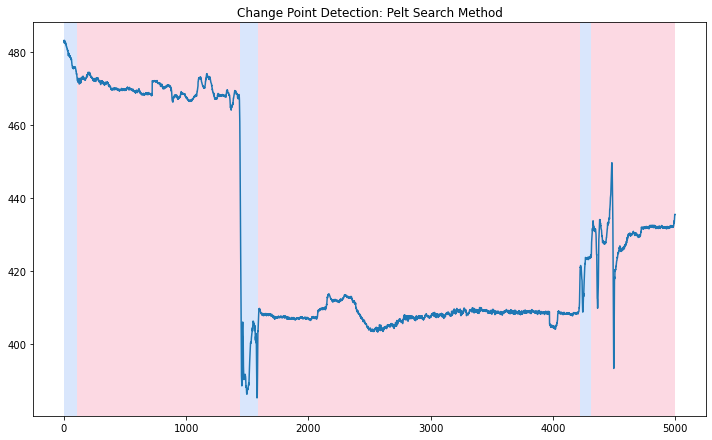

In [103]:
import ruptures as rpt
pawLeftx = DLC_aligned["PawL"][DLC_aligned["PawL"]["likelihood"] > 0.95]["x"][5000:10000].values
# ts_score1 = findChangePoints(pawLeftx, r = 0.01, order = 3, smooth = 5)

model="rbf"
algo = rpt.Pelt(model=model).fit(pawLeftx)
result = algo.predict(pen=10)
rpt.display(pawLeftx, result, figsize=(10, 6))
plt.title('Change Point Detection: Pelt Search Method')
plt.show()  


(array([1580, 4498]),
 {'prominences': array([64.28863525, 42.12445068]),
  'left_bases': array([   2, 4483]),
  'right_bases': array([4483, 4998])})

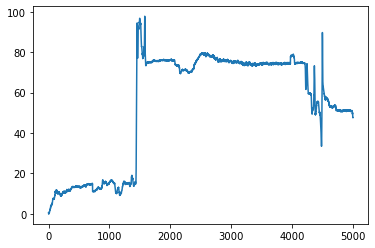

In [108]:
plx = np.max(pawLeftx) - pawLeftx
plt.plot(plx)

from scipy.signal import find_peaks
find_peaks(plx, prominence=(30 ,np.max(plx)))


In [11]:
def segment(arr, max=20):
    """
    This function takes an array and clusters them according to the max value. We use these to
    cluster licks from TongueTip positions
    """
    clusters = []
    eps = max
    points_sorted = np.asarray(arr)
    curr_point = points_sorted[0]
    curr_cluster = [curr_point]
    for point in points_sorted[1:]:
        if point <= curr_point + eps:
            curr_cluster.append(point)
        else:
            clusters.append(curr_cluster)
            curr_cluster = [point]
            curr_point = point
    clusters.append(curr_cluster)

    return clusters


Int64Index([4016, 4021, 4022, 4023, 4024, 4025, 4045, 4046, 4047, 4051,
            ...
            9951, 9952, 9953, 9965, 9967, 9968, 9969, 9970, 9971, 9973],
           dtype='int64', length=811)
[4016, 4220, 4438, 4683, 4906, 5125, 5344, 5585, 5816, 6023, 6228, 6429, 6643, 6861, 7066, 7267, 7470, 7673, 7887, 8092, 8307, 8536, 8737, 8955, 9162, 9363, 9580, 9790]


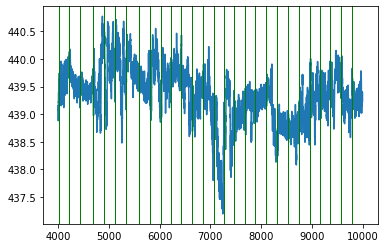

In [41]:
p=10 #instead of measuring difference from previous 1, can measure longer-distance differences
import pandas as pd

pawLeftx = DLC_aligned["EyeDown"][DLC_aligned["EyeDown"]["likelihood"] > 0.95]["x"][4000:10000]

np.savetxt("pawlx.txt", pawLeftx)
s = pawLeftx
diffs = s.diff(periods=p)
std = diffs.std()
significant_changes = diffs.loc[diffs > std].index
print(significant_changes)
seg = segment(significant_changes, 200)
significant_changes = [seg[i][0] for i in range(len(seg))]
print(significant_changes)
plt.plot(pawLeftx)
[plt.axvline(significant_changes[i], linewidth=1, color='g') for i in range(len(significant_changes))]
plt.show()

In [31]:
diffs.std()

3.2444152794878787

In [1]:
dlc_base_dir = os.path.abspath("../bucket/Data/Behavior_videos/DLC_output/Bergamo-2P-Photostim/")
bpod_path = os.path.abspath("../bucket/Data/Behavior/BCI_exported/Bergamo-2P-Photostim/")
suite2p_path = os.path.abspath("../bucket/Data/Calcium_imaging/suite2p/Bergamo-2P-Photostim/")
sessionwise_data_path = os.path.abspath("../bucket/Data/Calcium_imaging/sessionwise_tba/")
plt_save_path = os.path.abspath("../Plots/")
aligned_data_path = os.path.abspath("/home/labadmin/Github/BCI_analysis/data_aligned")


mouse = "BCI_26"
FOV = "FOV_04"
camera = "side" 
session = "041022"
sys.path.append("/home/labadmin/Github/BCI_analysis/BCI_analysis/")

import importlib
import sys
from io_bci.io_suite2p import suite2p_to_npy
importlib.reload(sys.modules['io_bci.io_suite2p'])

<module 'io_bci.io_suite2p' from '/home/labadmin/Github/BCI_analysis/BCI_analysis/io_bci/io_suite2p.py'>

In [17]:
mice_name = "BCI_26"
suite2p_path = os.path.abspath("../bucket/Data/Calcium_imaging/suite2p/Bergamo-2P-Photostim/")
raw_data_path = "../bucket/Data/Calcium_imaging/raw/Bergamo-2P-Photostim/"
behavior_data_path = "../bucket/Data/Behavior/BCI_exported/Bergamo-2P-Photostim/"
save_path = "../bucket/Data/Calcium_imaging/sessionwise_tba"

suite2p_to_npy(suite2p_path, 
                   raw_data_path, 
                   behavior_data_path, 
                   save_path, 
                   overwrite=True, 
                   mice_name=mice_name, 
                   fov_list=["FOV_04"], 
                   session_list=["041122"],
                   max_frames = 240,
                   frames_prev_trial = 40)


FOV: FOV_04, Session Date: 041122
Saved to ../bucket/Data/Calcium_imaging/sessionwise_tba/BCI_26/BCI_26-041122-FOV_04.npy


In [5]:
import numpy as np
a = np.load("../bucket/Data/Calcium_imaging/sessionwise_tba/BCI_26/BCI_26-041022-FOV_04.npy", allow_pickle=True).tolist()

In [3]:
from io_bci.io_suite2p import sessionwise_to_trialwise
from numpy import array

importlib.reload(sys.modules['io_bci.io_suite2p'])
# fnum = [200, 200, 176, 200, 200, 96, 200, 91, 200, 200, 200, 200, 200, 200, 168, 238, 162, 204, 173, 158, 195, 159, 250, 246, 237, 194, 231, 219, 210, 555, 231, 161, 211, 251, 482, 256, 241, 179, 269, 181, 123, 368, 216, 260, 214, 321, 158, 155, 407, 245, 144, 106, 229, 290, 236, 202, 195, 147, 235, 237, 246, 110, 313, 178, 266, 397, 157, 196, 203, 225, 203, 237, 252, 326, 237, 202, 156, 121, 170, 181, 168, 190, 214, 237, 168, 656, 209, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 18]
# sfn = [array(['neuron5_00001.tif'], dtype='<U19'), array(['neuron5_00002.tif'], dtype='<U19'), array(['neuron5_00003.tif'], dtype='<U19'), array(['neuron5_00004.tif'], dtype='<U19'), array(['neuron5_00005.tif'], dtype='<U19'), array(['neuron5_00006.tif'], dtype='<U19'), array(['neuron5_00007.tif'], dtype='<U19'), array(['neuron5_00008.tif'], dtype='<U19'), array(['neuron5_00009.tif'], dtype='<U19'), array(['neuron5_00010.tif'], dtype='<U19'), array(['neuron5_00011.tif'], dtype='<U19'), array(['neuron5_00012.tif'], dtype='<U19'), array(['neuron5_00013.tif'], dtype='<U19'), array(['neuron5_00014.tif'], dtype='<U19'), array(['neuron5_00015.tif'], dtype='<U19'), array(['neuron5_00016.tif'], dtype='<U19'), array(['neuron5_00017.tif'], dtype='<U19'), array(['neuron5_00018.tif'], dtype='<U19'), array(['neuron5_00019.tif'], dtype='<U19'), array(['neuron5_00020.tif'], dtype='<U19'), array(['neuron5_00021.tif'], dtype='<U19'), array(['neuron5_00022.tif'], dtype='<U19'), array(['neuron5_00023.tif'], dtype='<U19'), array(['neuron5_00024.tif'], dtype='<U19'), array(['neuron5_00025.tif'], dtype='<U19'), array(['neuron5_00026.tif'], dtype='<U19'), array(['neuron5_00027.tif'], dtype='<U19'), array(['neuron5_00028.tif'], dtype='<U19'), array(['neuron5_00029.tif'], dtype='<U19'), array(['neuron5_00030.tif'], dtype='<U19'), array(['neuron5_00031.tif'], dtype='<U19'), array(['neuron5_00032.tif'], dtype='<U19'), array(['neuron5_00033.tif'], dtype='<U19'), array(['neuron5_00034.tif'], dtype='<U19'), array(['neuron5_00035.tif'], dtype='<U19'), array(['neuron5_00036.tif'], dtype='<U19'), array(['neuron5_00037.tif'], dtype='<U19'), array(['neuron5_00038.tif'], dtype='<U19'), array(['neuron5_00039.tif'], dtype='<U19'), array(['neuron5_00040.tif'], dtype='<U19'), array(['neuron5_00041.tif'], dtype='<U19'), array(['neuron5_00042.tif'], dtype='<U19'), array(['neuron5_00043.tif'], dtype='<U19'), array(['neuron5_00044.tif'], dtype='<U19'), array(['neuron5_00045.tif'], dtype='<U19'), array(['neuron5_00046.tif'], dtype='<U19'), array(['neuron5_00047.tif'], dtype='<U19'), array(['neuron5_00048.tif'], dtype='<U19'), array(['neuron5_00049.tif'], dtype='<U19'), array(['neuron5_00050.tif'], dtype='<U19'), array(['neuron5_00051.tif'], dtype='<U19'), array(['neuron5_00052.tif'], dtype='<U19'), array(['neuron5_00053.tif'], dtype='<U19'), array(['neuron5_00054.tif'], dtype='<U19'), array(['neuron5_00055.tif'], dtype='<U19'), array(['neuron5_00056.tif'], dtype='<U19'), array(['neuron5_00057.tif'], dtype='<U19'), array(['neuron5_00058.tif'], dtype='<U19'), array(['neuron5_00059.tif'], dtype='<U19'), array(['neuron5_00060.tif'], dtype='<U19'), array(['neuron5_00061.tif'], dtype='<U19'), array(['neuron5_00062.tif'], dtype='<U19'), array(['neuron5_00063.tif'], dtype='<U19'), array(['neuron5_00064.tif'], dtype='<U19'), array(['neuron5_00065.tif'], dtype='<U19'), array(['neuron5_00066.tif'], dtype='<U19'), array(['neuron5_00067.tif'], dtype='<U19'), array(['neuron5_00068.tif'], dtype='<U19'), array(['neuron5_00069.tif'], dtype='<U19'), array(['neuron5_00070.tif'], dtype='<U19'), array(['neuron5_00071.tif'], dtype='<U19'), array(['neuron5_00072.tif'], dtype='<U19'), 'no movie for this trial']


<module 'io_bci.io_suite2p' from '/home/labadmin/Github/BCI_analysis/BCI_analysis/io_bci/io_suite2p.py'>

In [10]:
t = sessionwise_to_trialwise(a['F_sessionwise'], a['all_si_filenames'], a['closed_loop_filenames'], a['all_si_frame_nums'], a['sampling_rate'], go_cue_times=a['go_cue_times'], frames_before=40, frames_after=200)

In [6]:
dffs = (a['F_sessionwise'] - np.nanstd(a['F_sessionwise'], axis=1, keepdims=True))/np.nanstd(a['F_sessionwise'], axis=1, keepdims=True)
# s = sessionwise_to_trialwise(dffs, a['all_si_filenames'], a['closed_loop_filenames'], fnum, a['sampling_rate'], go_cue_times=a['go_cue_times'], reward_times = a['reward_times'], align_on="reward", frames_before=40, frames_after=200)

In [7]:
l = sessionwise_to_trialwise(dffs, a['all_si_filenames'], a['closed_loop_filenames'], fnum, a['sampling_rate'], go_cue_times=a['go_cue_times'], reward_times = a['reward_times'], align_on="trial_start", max_frames="all")

Since max_frames is all, this function will return a list of F trialwise as all trials have different lengths
k
k
k
k
k
k
k
k
k
k
k
k
k
k
k
2731 2969
2969 3131
3131 3335
3335 3508
3508 3666
3666 3861
3861 4020
4020 4270
4270 4516
4516 4753
4753 4947
4947 5178
5178 5397
5397 5607
5607 6162
6162 6393
6393 6554
6554 6765
6765 7016
7016 7498
7498 7754
7754 7995
7995 8174
8174 8443
8443 8624
8624 8747
8747 9115
9115 9331
9331 9591
9591 9805
9805 10126
10126 10284
10284 10439
10439 10846
10846 11091
11091 11235
11235 11341
11341 11570
11570 11860
11860 12096
12096 12298
12298 12493
12493 12640
12640 12875
12875 13112
13112 13358
13358 13468
13468 13781
13781 13959
13959 14225
14225 14622
14622 14779
14779 14975
14975 15178
15178 15403
15403 15606
15606 15843
15843 16095
16095 16421
16421 16658
16658 16860
16860 17016
17016 17137
17137 17307
17307 17488
17488 17656
17656 17846
17846 18060
18060 18297
18297 18465
18465 19121
19121 19330
k
k
k
k
k
k
k
k
k
k
k
k
k
k
k
k
k
k
k
k
k
k
k
k
k
k


In [12]:
l[2].shape

(204, 887)

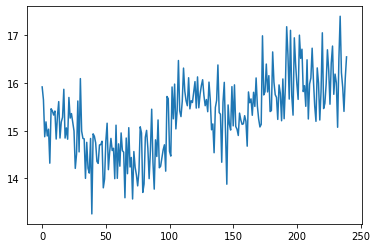

In [11]:
import matplotlib.pyplot as plt
plt.plot(np.nanmean(t[:, 0, :], axis=-1))
# plt.plot(np.nanmean(s[:, 0, :], axis=-1))

In [12]:
plt.imshow(np.nanmean(s, axis=-1).T, aspect="auto", cmap='seismic')

NameError: name 's' is not defined

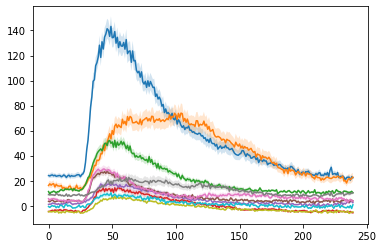

In [14]:
k = np.nanmean(t, axis=-1)
sd =  np.nanstd(t, axis=-1)
k = k - np.mean(k[:20, :])
means = np.mean(k[40:50, :], axis=0) - np.mean(k[30:40, :], axis=0)
sorted_m = np.argsort(means)[::-1]
# plt.imshow(k[:100, sorted_m[:50]].T, aspect='auto', cmap='seismic')
for i in sorted_m[:10]:
    plt.plot(k[:, i])
    plt.fill_between(np.arange(k.shape[0]), k[:, i]+sd[:, i]/np.sqrt(t.shape[-1]), k[:, i]-sd[:, i]/np.sqrt(t.shape[-1]), alpha=0.2)


In [57]:
k = np.nanmean(t, axis=-1)
k = k - np.mean(k[:20, :])


In [58]:
k

array([[-1.93302133, 31.02420435,  5.77767928, ..., -3.46708047,
        -4.34807701, -0.36477304],
       [-2.20232171, 30.26889761,  4.60993202, ..., -4.16418609,
        -4.20330916, -0.22667912],
       [-2.9747375 , 31.80800938,  5.58765729, ..., -3.73096173,
        -4.63772401,  1.71757937],
       ...,
       [-2.44473681, 31.64719223,  3.98412108, ..., -3.64056205,
        -3.31806267,  0.18549454],
       [-1.75410165, 31.51241936,  6.08541383, ..., -4.01235955,
        -4.16142008,  1.21741826],
       [-1.30464907, 31.09150194,  4.78516554, ..., -3.47146503,
        -5.59504992,  0.30164511]])

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import os, sys

sys.path.append("/home/labadmin/Github/BCI_analysis/BCI_analysis/")
# from pipeline.pipeline_align import get_aligned_data
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
# from plot_utils import rollingfun
from sklearn.decomposition import PCA

dlc_base_dir = os.path.abspath("../bucket/Data/Behavior_videos/DLC_output/Bergamo-2P-Photostim/")
bpod_path = os.path.abspath("../bucket/Data/Behavior/BCI_exported/Bergamo-2P-Photostim/")
suite2p_path = os.path.abspath("../bucket/Data/Calcium_imaging/suite2p/Bergamo-2P-Photostim/")
sessionwise_data_path = os.path.abspath("../bucket/Data/Calcium_imaging/sessionwise_tba/")
plt_save_path = os.path.abspath("../Plots/")

mouse = "BCI_26"
FOV = "FOV_04"
camera = "side" 
session = "041022"

# from ..pipeline.pipeline_align import align_licks


In [9]:
def interpolate_ca_data(dlc_trial, F_trial, plot=False):
    x = np.linspace(0, dlc_trial.shape[0], F_trial.shape[1])
    xnew = np.arange(0, dlc_trial.shape[0])
    F_ret = np.zeros((F_trial.shape[0], dlc_trial.shape[0]))
    for i in range(F_trial.shape[0]):
        y = F_trial[i, :]
        f = interpolate.interp1d(x, y)
        ynew = f(xnew)
        F_ret[i, :] = ynew
    if plot:
        plt.plot(x, y, 'o', xnew, ynew, '-')
        plt.show()
    return F_ret

In [10]:

bpod_filepath = os.path.join(bpod_path, mouse, session+"-bpod_zaber.npy")
bpod_data = np.load(bpod_filepath, allow_pickle=True).tolist()
behavior_movie_names = bpod_data['behavior_movie_name_list'][:-1]
trial_start_times = bpod_data['trial_start_times']

ca_data = np.load(os.path.join(sessionwise_data_path, mouse, mouse+"-"+session+"-"+FOV+".npy"), allow_pickle=True).tolist()
F = ca_data['F_sessionwise']
fs = ca_data['sampling_rate']
lick_times = ca_data['lick_times']
reward_times = ca_data['reward_times']
trial_times = ca_data['trial_times']

with open(os.path.join(suite2p_path, mouse, FOV, session, "filelist.json")) as f:
    filelist = json.load(f)

cl_trial_list = [filelist['file_name_list'][i] for i in range(len(filelist['frame_num_list'])) if filelist['file_name_list'][i].startswith("neuron")]
print(len(cl_trial_list),len(behavior_movie_names), len(trial_start_times))

F_behavior = []
dff_behavior = []
lt = []
rt = []
ltrel = []
rtrel = []
dlc_data = None

for i, bm_name in tqdm(enumerate(behavior_movie_names)):

    if type(bm_name) == str:
        print(f"{camera} camera not found for trial {i}, skipping")
        continue
    
    camera_movies = []
    for video_file in bm_name:
        if camera in video_file: 
            camera_movies.append(video_file)
    
    if len(camera_movies) == 0:
        print(f"{camera} camera not found for trial {i}, skipping")
        continue
    elif len(camera_movies) > 1:
        print(f"Multiple {camera} camera files found for trial {i}, skipping")
        continue
    
    video_path = camera_movies[0]
    dlc_file_name = video_path[video_path.find(camera)+len(camera)+1:].split("/") #[mouse, session_id, trial_id]
    dlc_folder = os.path.join(dlc_base_dir, camera, dlc_file_name[0], dlc_file_name[1])
    trial_id = dlc_file_name[2][:-5]

    trial_json = os.path.join(dlc_folder, trial_id+".json")
    with open(trial_json) as f:
        trial_metadata = json.load(f)
    
    frame_times_rel0 = (trial_start_times[i] - trial_start_times[0]).total_seconds() + np.asarray(trial_metadata['frame_times'])
    F_trial = F[:, int(frame_times_rel0[0]*fs):int(frame_times_rel0[-1]*fs)]


    trial_csv = [k for k in next(os.walk(dlc_folder))[2] if k.startswith(trial_id) and k.endswith("csv")][0]
    # dlc_trial = pd.read_csv(os.path.join(dlc_folder, trial_csv), header=[1,2], index_col=0).drop('likelihood', level=1, axis=1)
    dlc_trial = pd.read_csv(os.path.join(dlc_folder, trial_csv), header=[1,2], index_col=0)
    # dlc_trial = collapse_dlc_data(dlc_trial, F_trial.shape[1], mode='edge')

    if i == 0:
        ltimes = list((lick_times[i])*(dlc_trial.shape[0]/trial_times[i]))
        rtimes = list((reward_times[i])*(dlc_trial.shape[0]/trial_times[i]))

        ltimes_rel = list((lick_times[i])*(dlc_trial.shape[0]/trial_times[i]))
        rtimes_rel = list((reward_times[i])*(dlc_trial.shape[0]/trial_times[i]))

    else:
        ltimes = list((lick_times[i])*(dlc_trial.shape[0]/trial_times[i]) + dlc_data.shape[0])
        rtimes = list((reward_times[i])*(dlc_trial.shape[0]/trial_times[i]) + dlc_data.shape[0])

        ltimes_rel = list((lick_times[i])*(dlc_trial.shape[0]/trial_times[i]))
        rtimes_rel = list((reward_times[i])*(dlc_trial.shape[0]/trial_times[i]))

    dlc_data = pd.concat([dlc_data, dlc_trial], ignore_index=True)
    F_trial = interpolate_ca_data(dlc_trial, F_trial)

    sd = np.nanstd(F_trial, axis=1).reshape(-1, 1)
    dff_trial = (F_trial - sd)/sd
    dff_trial = dff_trial - np.nanmean(dff_trial[:, :800], axis=1).reshape(-1, 1)

    F_behavior.append(F_trial)
    dff_behavior.append(dff_trial)
    lt.append([int(k) for k in ltimes])
    rt.append([int(k) for k in rtimes])

    ltrel.append([int(k) for k in ltimes_rel])
    rtrel.append([int(k) for k in rtimes_rel])

trial_lengths = [F_behavior[i].shape[1] for i in range(len(F_behavior))]

dff_behavior = np.hstack(F_behavior)
F_behavior = np.hstack(F_behavior)
# dff_behavior = np.hstack(dff_behavior)


72 72 73


14it [00:09,  1.38it/s]

Multiple side camera files found for trial 14, skipping


72it [00:54,  1.32it/s]


In [20]:
ltimes_rel

[]

IndexError: list index out of range

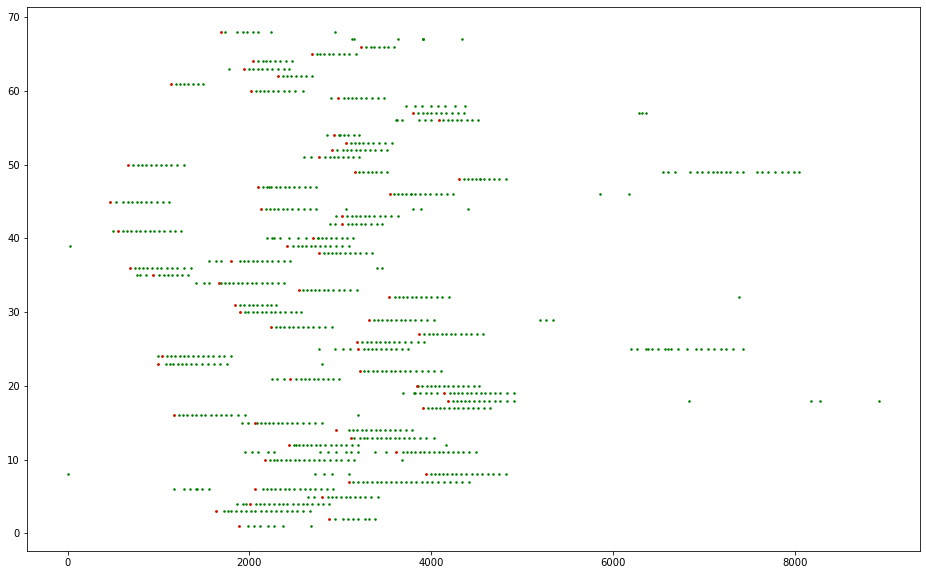

In [15]:
plt.figure(figsize=(16, 10))
for i in range(len(lt)-1):
    plt.plot(ltrel[i], [i]*len(ltrel[i]), 'go', markersize=1.5)    
    plt.plot(rtrel[i], [i]*len(rtrel[i]), 'ro', markersize=1.5)

plt.ylabel("Trial #")
plt.xlabel("Time from trial start")
plt.show()

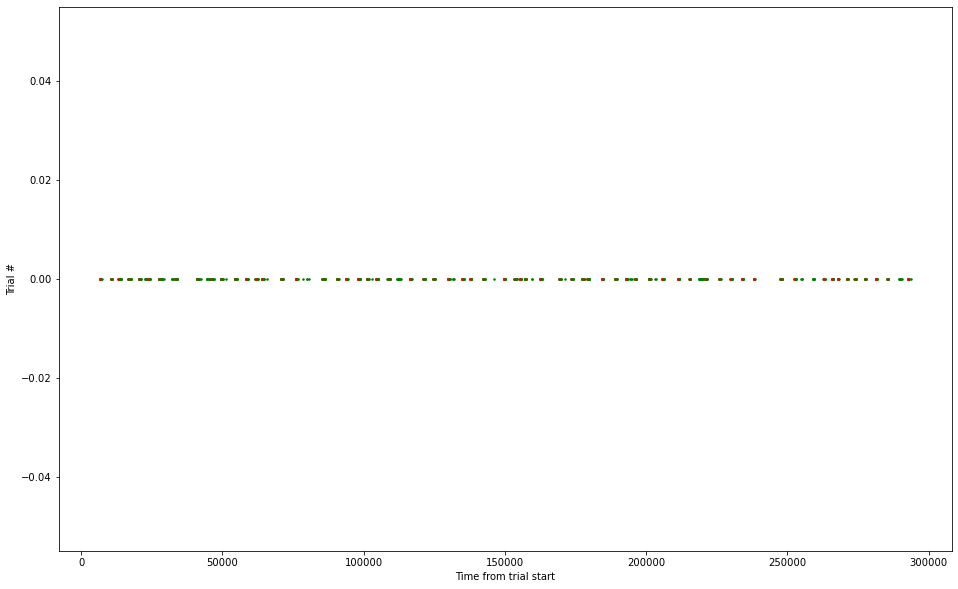

In [12]:
lt = sum(lt, [])
rt = sum(rt, [])
plt.figure(figsize=(16, 10))
# for i in range(len(lt)):
plt.plot(lt, [0]*len(lt), 'go', markersize=1.5)    
plt.plot(rt, [0]*len(rt), 'ro', markersize=1.5)

plt.ylabel("Trial #")
plt.xlabel("Time from trial start")
plt.show()

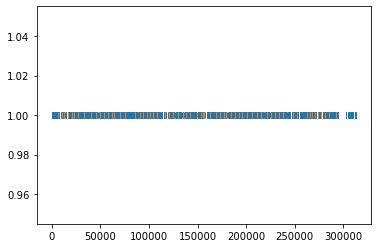

In [187]:
# import matplotlib
# matplotlib.use("qtagg")

grad = (np.gradient(dlc_data["TongueTip"]["x"]) > 50).astype('double')
grad[grad == 0.0] = np.nan
plt.plot(grad, '|')
plt.plot(rt, [1]*len(rt), '|')
plt.show()

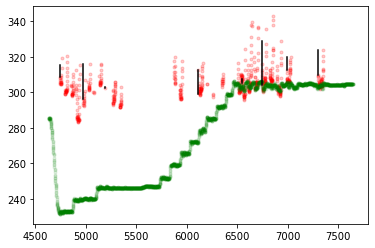

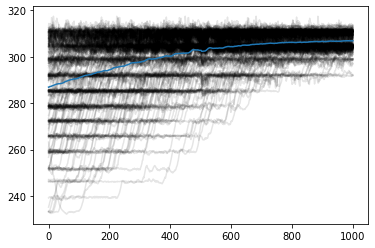

In [188]:
def segment(arr, max=20):
    clusters = []
    eps = max
    points_sorted = np.asarray(arr)
    curr_point = points_sorted[0]
    curr_cluster = [curr_point]
    for point in points_sorted[1:]:
        if point <= curr_point + eps:
            curr_cluster.append(point)
        else:
            clusters.append(curr_cluster)
            curr_cluster = [point]
            curr_point = point
    clusters.append(curr_cluster)

    return clusters

ttip = []
lport = []
tmid = []
c_lengths = [0] + list(np.cumsum(trial_lengths))

for i in range(len(c_lengths)-2):
    k = dlc_data["TongueTip"][c_lengths[i]:c_lengths[i+1]]
    ttip.append(k[k["likelihood"] > 0.90])

    k = dlc_data["TongueMid"][c_lengths[i]:c_lengths[i+1]]
    tmid.append(k[k["likelihood"] > 0.90])

    k = dlc_data["Lickport"][c_lengths[i]:c_lengths[i+1]]
    lport.append(k)

def plot_licks(ttip, tmid, lport, trial):

    k = segment(ttip[trial].index.values, max=200)
    tongue_start_end = np.array([[k[i][0], k[i][-1]] for i in range(len(k))])

    plt.scatter(ttip[trial].index.values, ttip[trial]["x"],  marker='.', alpha=0.2, c='red')
    # plt.scatter(tmid[trial].index.values, tmid[trial]["x"],  marker='.', alpha=0.2, c='blue')

    for i in range(tongue_start_end.shape[0]):
        plt.plot([tongue_start_end[i, 0], tongue_start_end[i, 0]], [ttip[trial]["x"][tongue_start_end[i, 0]], ttip[trial]["x"][tongue_start_end[i, 1]]], '-', color='black', alpha=1)
    plt.scatter(lport[trial]["x"].index.values, lport[trial]["x"],  marker='.', alpha=0.1, c='green')
    plt.show()
    # plt.xlim([0, 500])
plot_licks(ttip, tmid, lport, 1)


ctr=0
lick_starts = []
avg = [0]*1001
for trial in range(len(ttip)):
    arr = ttip[trial].index.values
    if len(arr) == 0:
        continue
    k = segment(arr, max=200)
    tongue_start_end = np.array([k[i][0] for i in range(len(k))])
    for i in range(tongue_start_end.shape[0]):
        movement = lport[trial]["x"].loc[tongue_start_end[i] - 500: tongue_start_end[i] + 500].values
        if np.mean(movement[500:]) < 290:
            ignore = True
            continue
        if movement.shape[0] != 1001:
            continue
        
        lick_starts.append(tongue_start_end[i])
        ctr = ctr + 1

        # movement = (movement - np.mean(movement))/np.std(movement)
        avg = avg + movement.flatten()

        plt.plot(movement, alpha=0.1, color='black')
    # plt.show()
plt.plot(avg/ctr)

In [189]:
cn = ca_data["cn"][0]

In [190]:
print(ctr)

330


In [192]:
dff_lt = np.zeros((400, dff_behavior.shape[0], len(lick_starts)))

for i in range(len(lick_starts)):
    dff_lt[:, :, i] = dff_behavior[:, lick_starts[i]-200:lick_starts[i]+200].T

In [ ]:
dff_lta = np.mean(dff_lt, axis=-1)

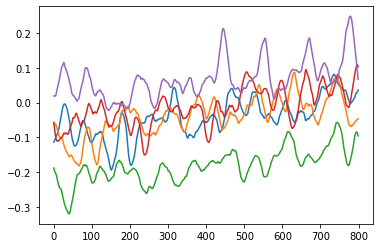

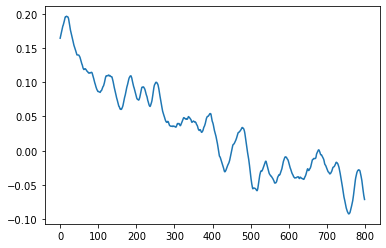

In [ ]:
means = []
for i in range(dff_lta.shape[1]):
    # normalize = Standard
    movement = dff_lta[:, i]
    # movement = (movement - np.mean(movement))/np.std(movement)
    means.append(np.mean(movement[400:]) - np.mean(movement[:400]))

sorted_m = np.argsort(means)[::-1][:5]

for i in sorted_m:
    movement = dff_lta[:, i]
    plt.plot(movement)
plt.show()
plt.plot(dff_lta[:, cn])

No reward trial, 0
No reward trial, 9
Not found
Not found
Not found
Not found
Not found
Not found
Not found
Not found
Not found
Not found
Not found
No reward trial, 56
No reward trial, 59
Not found
Not found
No reward trial, 68


/tmp/ipykernel_408610/1512717906.py:19: UserWarning: Attempting to set identical bottom == top == -0.5 results in singular transformations; automatically expanding.
  plt.imshow(dff_avg[sorted_m], aspect="auto")


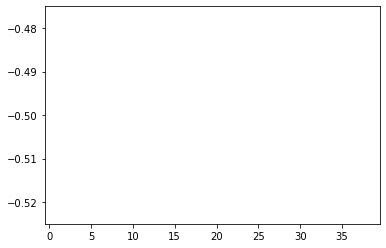

In [ ]:

dff_avg = np.zeros((dff_trial.shape[0], 40, len(c_lengths)-2))
for tl in range(len(c_lengths)-2):
    dff_trial = dff_behavior[:, c_lengths[tl]:c_lengths[tl+1]]
    reward = reward_times[tl]*fs

    if len(reward) == 0:
        print(f"No reward trial, {tl}")
        continue
    
    k = dff_trial[:, int(reward[0])-20: int(reward[0])+20]
    if k.shape[1] != 40:
        print("Not found")
        continue
    dff_avg[:,:,tl] = k

dff_avg = np.mean(dff_avg, axis=-1)
means = np.mean(dff_avg[:, 40:], axis=0)
sorted_m = np.argsort(means)[::-1]
plt.imshow(dff_avg[sorted_m], aspect="auto")
plt.show()

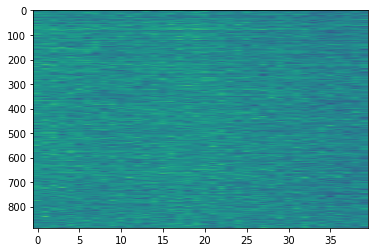

In [ ]:
plt.imshow(dff_avg, aspect='auto')

In [155]:
dff_trial

array([[ 6.19381428e-01,  2.29105663e+00,  5.23760557e-01, ...,
        -1.38524532e-01,  3.28545570e-01,  4.66456413e-02],
       [-1.64930165e-01,  4.93621826e-02, -6.71644926e-01, ...,
         1.46355712e+00,  1.26036179e+00,  1.52481568e+00],
       [ 2.13830650e-01, -2.27493793e-01,  6.18800282e-01, ...,
        -5.33729911e-01, -1.09356642e-03, -7.13166833e-01],
       ...,
       [-2.21857429e-01, -4.47310090e-01, -1.23631716e-01, ...,
        -4.68110085e-01,  1.28339088e+00, -1.00886261e+00],
       [-1.08578253e+00,  5.38158536e-01,  1.37603402e-01, ...,
        -1.26247346e+00, -5.15536189e-01,  2.90071964e-03],
       [-4.14604425e-01, -6.50671005e-01, -1.34778261e+00, ...,
        -7.42468953e-01, -5.15141129e-01, -6.02582693e-01]], dtype=float32)

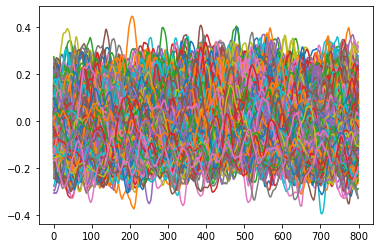

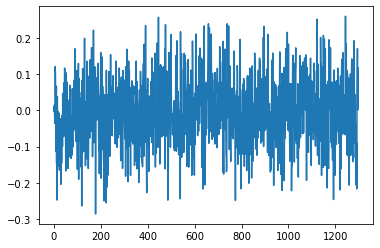

In [103]:
means = []
for i in range(dff_avg.shape[0]):
    movement = dff_avg[i, :]

sorted_m = np.argsort(means)[::-1]

for i in sorted_m:
    movement = dff_avg[i, :]
    plt.plot(movement)
plt.show()
plt.plot(dff_avg[:, cn])

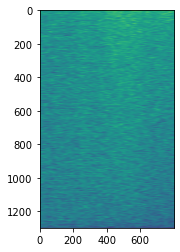

In [104]:
plt.imshow(dff_avg[sorted_m])

In [101]:
sorted_m

array([ 66, 686, 341, 718, 608])